In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# InteractiveShell.ast_node_interactivity = "last_expr"
import sys
import os

sys.path.insert(0, '/nas/xd/projects/transformers/src')
os.environ['HF_HOME'] = '/raid/xd/.cache/torch'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from itertools import chain
import math
from functools import reduce
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import random
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, pipeline
from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM, AutoModelForCausalLM

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM, GPTJForCausalLM
import pysvelte as ps 
import unseal
import string
from itertools import product, chain
import math
import json
from IPython.display import HTML, display

import torch
from unseal import transformers_util as tutil
from unseal import hooks
import unseal.visuals.utils as utils
from unseal.hooks import HookedModel


from utils import *
# from child_utils import *
from common_utils import *
# from model_utils import *
from weight_analysis import *

In file_utils.py: default_cache_path = /raid/xd/.cache/torch/hub


In [3]:
from utils_nrk import *
import pandas as pd
import matplotlib.pyplot as plt

# 载入模型

In [4]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-j-6B on elderberry

proxies = {'http': '192.168.50.1:1081'} 
model_name = "EleutherAI/gpt-j-6B"

# model_name = "EleutherAI/gpt-neo-1.3B"
model = GPTJForCausalLM.from_pretrained(model_name, proxies=proxies, cache_dir=cache_dir)
# model = AutoModelForCausalLM.from_pretrained(model_name, proxies=proxies, cache_dir=cache_dir)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
models[model_name] = model, tokenizer

In [169]:
import copy
from math import log, exp
def find_position(head_list, num): #num查询第几句话,查询全部可以用循环
    pos = {}
    text = tokenizer.encode_plus(head_list[num][0], return_tensors='pt')
    for k,v in head_list[num][1].items():
#         pos[k] = [l[0][0] for l in v]
        pos[k] = [(l[0][0],l[0][1]) for l in v]
    return text,pos

def create_mask(head, position, length):
    mask = torch.ones(16,length)
    mask[head, position] = 0
    return mask

def pred_right(Data, input_ids, out, pos):
    data = copy.deepcopy(Data)
    result = input_ids[0][pos+1:] == out.logits[0].argmax(1)[pos:-1]
    for i in range(len(data)):
        data[i].append(None)
    
    for i in range(pos+1,len(data)):
        if result[i-pos-1] == True:
            data[i][-1] = out.logits[0, i-1].softmax(-1)[input_ids[0][i]].item()
            
    for i in range(len(data)):
        data[i].append(0)
        
    for i in range(pos+1,len(data)):
        if(data[i][-2] != None):
            data[i][-1] = log(data[i][-2],10) - log(data[i][-3],10)
            
    data1 = []        
    for i in data:
        if(i[-1] != 0):
            data1.append(i)
            
    return data1

def show_difference_of_probability(data,layer, head, token):
    difference = pd.DataFrame(data, columns = ["token","清除前是否正确", "清除({},{}){}注意力前概率".format(layer,head,token),"清除({},{}){}注意力后概率".format(layer,head,token),"概率差"])   
    pd.set_option('display.max_rows', None)      
    return difference

head_list = load_list("1")
# which_sent = 1
# text,pos = find_position(head_list, which_sent)

In [ ]:
def Constructing_probability_matrix(out, length, position): #posotion：（行，列）,length:句子长度， out.logits[1,length,50400]
    zero = torch.zeros(length,length)
    

In [174]:
pos

{(5, 12): [(15, 8), (8, 1), (87, 81), (22, 18), (62, 8)],
 (7, 9): [(79, 19), (81, 24), (19, 16), (80, 19)],
 (7, 2): [(5, 2), (6, 2), (7, 2), (91, 85), (53, 47)],
 (6, 5): [(60, 53), (59, 53), (5, 3), (6, 3), (43, 27)],
 (3, 7): [(62, 45), (8, 2)],
 (8, 7): [(81, 19), (79, 58), (62, 45), (18, 8), (22, 8)],
 (6, 2): [(81, 19), (79, 16), (15, 8), (59, 33), (18, 8)],
 (3, 12): [(18, 16), (7, 3), (5, 3), (14, 7), (8, 2)]}

In [177]:
tokenizer.convert_ids_to_tokens([3])

['$']

In [170]:
def make(head_list,text, pos, which_sent, json_data):
    Data = []
    json_dict = {}
    
    #前传第一次，不清除注意力
    out = model(**text, output_attentions=True)
    token = tokenizer.convert_ids_to_tokens(text.input_ids[0][0])
    prob = 0 
    data = [token,0,prob]
    Data.append(data)
    for i in range(1,len(text.input_ids[0])):
        token = tokenizer.convert_ids_to_tokens(text.input_ids[0][i])
        right = 1 if out.logits[0].argmax(1)[i-1] == text.input_ids[0][i] else 0
        prob = out.logits[0, i-1].softmax(-1)[text.input_ids[0][i]].item()
        data = [token,right,prob]
        Data.append(data)

    #前传第二次，清除注意力

    for h,p in pos.items():
        data_dict = {}
        layer,head = h
        self = model.transformer.h[layer].attn
        for position in p:
            self.mask = create_mask(head, position[0], len(text.input_ids[0]))
            out = model(**text, output_attentions=True)
            data = pred_right(Data, text.input_ids, out, position[0])
            data_dict[text.input_ids[0][position[0]]] = data
            json_dict[(layer,head)] = data_dict
#             print("清除({},{}){}的注意力".format(layer,head,data1[position-1][0]))
#             difference = show_difference_of_probability(data1,layer,head,data1[position[0]-1][0])
#             difference
            del self.mask
        del self

    json_data.append([head_list[which_sent][0],json_dict])
    return json_data
#         print(out.attentions[0].size())
#         print(tokenizer.convert_ids_to_tokens(out.logits[0].argmax(1)[position:]))



# del data1, out, self.mask  

In [173]:
data = []
head_list = load_list("4")
for i in range(1):
    text,pos = find_position(head_list, 0)
    make(head_list, text, pos, 0, data)

[['Linguistics is the scientific study of language, and involves an analysis of language form, language meaning, and language in context. The earliest activities in the documentation and description of language have been attributed to the 4th century BCE Indian grammarian Pāṇini, who wrote a formal description of the Sanskrit language in his "Aṣṭādhyāyī ". Form and meaning are the only aspects of language linguistics is concerned with.',
  {(5,
    12): {tensor(3303): [[',',
      1,
      0.5463567972183228,
      0.5423471331596375,
      -0.003199001675184887],
     [',', 1, 0.8081072568893433, 0.8074039220809937, -0.0003781520666296667],
     ['Ġand',
      1,
      0.5396881103515625,
      0.5398269295692444,
      0.00011169537861765999],
     ['Ġlanguage',
      1,
      0.7718830704689026,
      0.766951858997345,
      -0.0027834112949194634],
     ['Ġcontext',
      1,
      0.2355586141347885,
      0.24066312611103058,
      0.00931056313692824],
     ['.', 1, 0.8092537522

In [167]:
head_list = load_list("1")
text,pos = find_position(head_list, 1)
out = model(**text, output_attentions=True)
out.logits[0, -3].softmax(-1)[ 2663]

tensor(0.5868, grad_fn=<SelectBackward0>)

In [165]:
text

{'input_ids': tensor([[29284,   373,   257,   881,  1365, 23923,   621, 14200,   523, 10490,
          1464,  1392,   262,  7069,  2663,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [60]:
# out.attentions[3][0][12]


In [61]:
Data

[['Ġgot', 0.19941839575767517],
 ['Ġthe', 0.43522724509239197],
 ['Ġcases', 0.5883460640907288],
 ['.', 0.5900899171829224]]

In [56]:
text.input_ids[0]
tokenizer.convert_ids_to_tokens(text.input_ids[0])

tensor([29284,   373,   257,   881,  1365, 23923,   621, 14200,   523, 10490,
         1464,  1392,   262,  7069,  2663,    13])

['Sarah',
 'Ġwas',
 'Ġa',
 'Ġmuch',
 'Ġbetter',
 'Ġsurgeon',
 'Ġthan',
 'ĠMaria',
 'Ġso',
 'ĠSarah',
 'Ġalways',
 'Ġgot',
 'Ġthe',
 'Ġharder',
 'Ġcases',
 '.']

In [28]:
out.logits[0].argmax(1)[10:-1]

tensor([1392,  262, 1365, 2663,   13, 1375])

In [130]:
mask = create_mask(1,1,5)
type(mask)
mask.size()

torch.Tensor

torch.Size([16, 5])

In [125]:
input_text = "Hello my name is Paul."
input_ids = tokenizer.encode_plus(str(input_text), return_tensors='pt')
# out = model(**input_ids)
# output = model.generate(
#     **input_ids,
# #     output_attentions = True,
#     output_scores = True,
# #     output_hidden_states = True,
#     do_sample=True,
#     max_length=20,
#     top_p=0.7,
#     top_k=0,
#     temperature=1.0,
#     num_return_sequences=5, 
# )
len(input_ids.input_ids[0])

6

In [167]:
out.logits[0, 2].softmax(-1)[318]
out.logits[0, -4].softmax(-1)[318]

tensor(0.9436, grad_fn=<SelectBackward0>)

tensor(0.9436, grad_fn=<SelectBackward0>)

In [179]:
out.logits[0].argmax(1)
out.logits[0].argmax(1)[2:]

tensor([2506, 1438,  318,  198,  290,  314])

tensor([318, 198, 290, 314])

In [97]:
tokenizer.convert_ids_to_tokens([2506, 1438,  318,  198,  290,  314])

['Ġeveryone', 'Ġname', 'Ġis', 'Ċ', 'Ġand', 'ĠI']

# 运行流程

# 运行部分

In [64]:
heads = [(5,12), (7,9) , (7,2) , (6,5) , (3,7) , (8,7) , (6,2) , (3,12)]
head_list = load_list("1")
rate = show_rate(head_list, heads)
rate

数据量： 1000


,出现次数,出现频率
"(7, 9)",736,0.736
"(5, 12)",831,0.831
"(3, 7)",927,0.927
"(7, 2)",948,0.948
"(3, 12)",994,0.994
"(6, 2)",996,0.996
"(6, 5)",1000,1.000
"(8, 7)",1000,1.000


In [77]:
distance = show_loc(head_list, (6, 5),tokenizer) #取最大的概率值的关注位置
distance

,被关注token,关注token,关注距离,对应文本编号,注意力分数
0,Ġdrafted,th,7,848,0.982632
1,e,or,6,791,0.978536
2,group,Ġof,6,150,0.978022
3,ater,Ġpartner,46,4,0.973400
4,Ġdrafted,th,8,329,0.970976
5,low,Ġthe,2,939,0.967920
6,ch,old,7,9,0.967769
7,ch,old,7,936,0.967769
8,Ġnovel,Ġby,5,43,0.967717
9,Ġname,ĠIt,5,551,0.966620


In [90]:
which_sentence(head_list,848)

Robert Quinn (born May 18, 1990) is an American football outside linebacker for the Los Angeles Rams of the National Football League (NFL). He played college football at North Carolina, and was drafted by the Rams with the 14th pick in the first round of the 2011 NFL Draft. Robert quinn was born in north carolina.


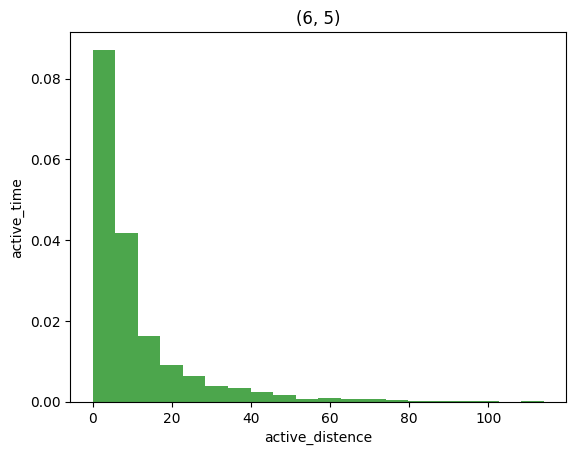

In [91]:
show_times_distence(head_list, [(6,5)],tokenizer)

In [30]:
import random
import einops
heads = [(5,12), (7,9) , (7,2) , (6,5) , (3,7) , (8,7) , (6,2) , (3,12)]
    
head_list = load_list("4")
# show_activation(model, tokenizer, head_list, heads, 848)
show_activations(model, tokenizer, head_list, heads, 3)

In [21]:
# import npm
# from contextlib import suppress
# from typing import Optional
# import random
# import pysvelte as ps 
# heads = [(5, 12), (7, 9)]

# texts = read_texts("5")
# head_dict = find_activations(model, tokenizer, texts, heads)
# dump_dict(head_dict)
# head_dict = load_dict()
# show_activations(model, tokenizer, head_dict, heads, 5)

In [42]:
text = "Avery was debating on taking up German instead of Latin, because the Latin was old."
sent = tokenizer.tokenize(text)

In [52]:
tokenized_text = list(map(tokenizer.convert_tokens_to_string, map(lambda x: x, sent))) 
print(tokenized_text)

['A', 'very', ' was', ' debating', ' on', ' taking', ' up', ' German', ' instead', ' of', ' Latin', ',', ' because', ' the', ' Latin', ' was', ' old', '.']


In [51]:
a = list(map(lambda x: x, sent))
print(a)

['A', 'very', 'Ġwas', 'Ġdebating', 'Ġon', 'Ġtaking', 'Ġup', 'ĠGerman', 'Ġinstead', 'Ġof', 'ĠLatin', ',', 'Ġbecause', 'Ġthe', 'ĠLatin', 'Ġwas', 'Ġold', '.']


In [6]:
# x = torch.randn(5, 5) #随机生成一个二维Tensor
# x = x[2:].detach().numpy()
# x1 = x
# x1 = torch.tensor(x1)
# print(x1)
# for i,j in enumerate(x1):
#     print("Max",max(j))
#     a = torch.squeeze((j==torch.max(j)).nonzero(),0)
#     if(a[0]!=0):
#         b = int(a[0])
#         c = (i,b)
#         print(type(c[0]))
#         print(j)
#         print(j[int(a[0])])
# print(x[a[0]][a[1]])